In [1]:
import umap
from sklearn.decomposition import PCA
from matplotlib.cm import get_cmap
from sklearn import linear_model
from sklearn.metrics import median_absolute_error
from sklearn.model_selection import train_test_split
import pandas as pd
from useful_funcs import load_df , fft_river_df
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from tqdm.contrib.concurrent import process_map
import time
import gc
from sklearn.manifold import TSNE


start_globals = set(globals().keys())

# -- River height --
river_depth_df = load_df('ingested_data/river_depth_data.csv')
river_depth_df = river_depth_df.interpolate(method='linear').interpolate(
    method='linear', limit_direction='backward')

# -- Precipitation --
precip_df = load_df('ingested_data/precip_data.csv')
precip_df2 = load_df('ingested_data/precip_data2.csv')

# if na can only make better by looking at next nearest df
for riv in list(precip_df):
    hashmap_for_orig = precip_df[riv].isna()
    precip_df.loc[hashmap_for_orig,
                  riv] = precip_df2.loc[hashmap_for_orig, riv]
precip_df = precip_df.interpolate(method='linear').interpolate(
    method='linear', limit_direction='backward')

# -- Temperature --
temp_df = load_df('ingested_data/temp_data.csv')
temp_df2 = load_df('ingested_data/temp_data2.csv')

# if na can only make better by looking at next nearest df
for riv in list(temp_df):
    hashmap_for_orig = temp_df[riv].isna()
    temp_df.loc[hashmap_for_orig,
                riv] = temp_df2.loc[hashmap_for_orig, riv]
temp_df = temp_df.interpolate(method='linear').interpolate(
    method='linear', limit_direction='backward')


2022-12-02 11:47:29.218018: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-02 11:47:29.284126: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
imperfect_final_rivs = []  # for train and validate
with open('eda_results/imperfect_final_rivs.txt', 'r') as in_file:
    imperfect_final_rivs = in_file.readline()[:-1].split(', ')
perfect_final_rivs = []  # for final test
with open('eda_results/perfect_final_rivs.txt', 'r') as in_file:
    perfect_final_rivs = in_file.readline()[:-1].split(', ')


# df name shortening:
# letter 1 = d (river depth), p (precipitation), t (temperature)
# letter 2 = i (imperfect), p (perfect)
di_df = river_depth_df.loc[:, imperfect_final_rivs]
pi_df = precip_df.loc[:, imperfect_final_rivs]
ti_df = temp_df.loc[:, imperfect_final_rivs]
dp_df = river_depth_df.loc[:, perfect_final_rivs]
pp_df = precip_df.loc[:, perfect_final_rivs]
tp_df = temp_df.loc[:, perfect_final_rivs]

In [3]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
train_rivs, validate_rivs = train_test_split(
    imperfect_final_rivs, test_size=0.33, random_state=42)

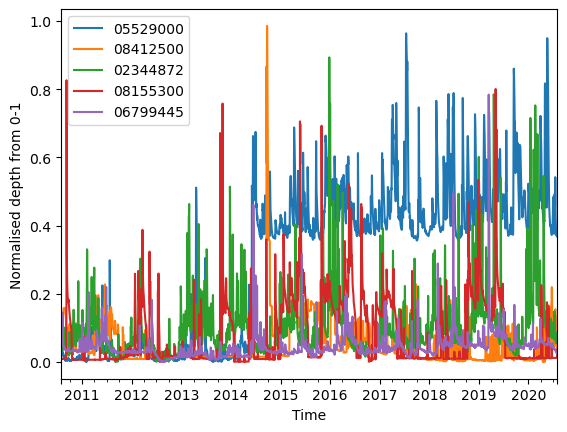

In [4]:
dtrain_df = di_df.loc[:, train_rivs]
normed_01_d_df = (dtrain_df - dtrain_df.min()) / dtrain_df.max()
normed_01_d_df.iloc[:, :5].plot()
plt.ylabel('Normalised depth from 0-1')
plt.xlabel('Time')
plt.show()
mean_std_d_df = (dtrain_df - dtrain_df.mean()) / dtrain_df.std()

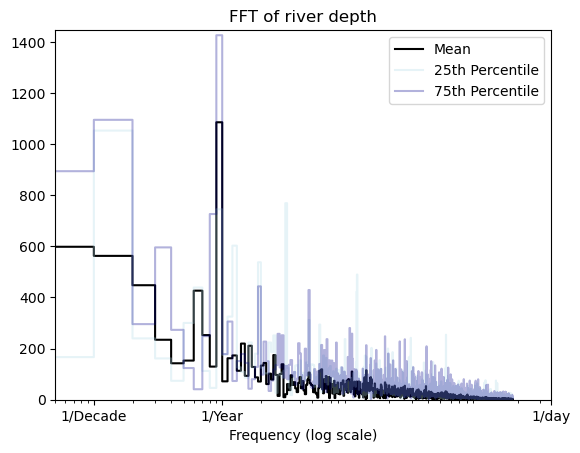

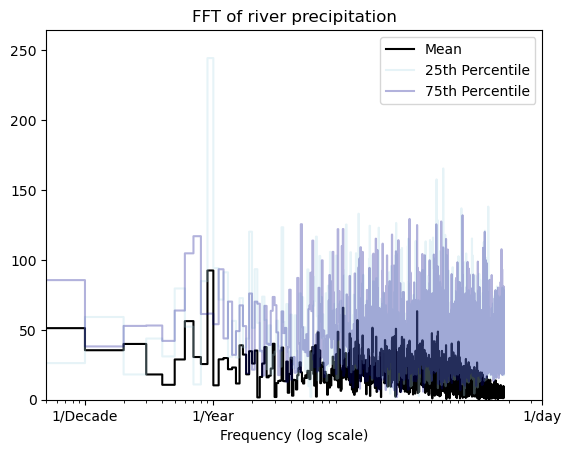

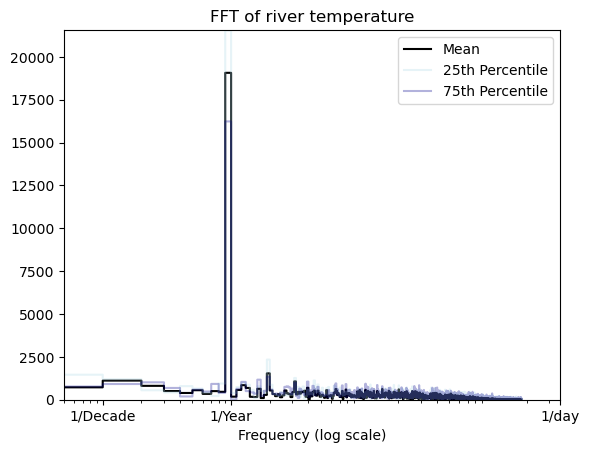

In [11]:
# Check frequencies in data
# not clear there is pattern any apart from yearly
ptrain_df = pi_df.loc[:, train_rivs]
ttrain_df = ti_df.loc[:, train_rivs]
fft_river_df(dtrain_df, 'depth')
fft_river_df(ptrain_df, 'precipitation')
fft_river_df(ttrain_df, 'temperature')

In [12]:
# Autocorrelation functions and data processing
print('--- Autocorrelation functions and data processing ---')

def d_autocorr_mean(row):
    return dtrain_df.apply(lambda col: col.autocorr(row), axis=0).to_numpy().mean()


def p_autocorr_mean(row):
    return ptrain_df.apply(lambda col: col.autocorr(row), axis=0).to_numpy().mean()


def t_autocorr_mean(row):
    return ttrain_df.apply(lambda col: col.autocorr(row), axis=0).to_numpy().mean()


print('Depth')
d_autocorrs = process_map(d_autocorr_mean, range(
    dtrain_df.shape[0]-2), max_workers=16, chunksize=5)
print('Precipitation')
p_autocorrs = process_map(p_autocorr_mean, range(
    ptrain_df.shape[0]-2), max_workers=16, chunksize=5)
print('Temperature')
t_autocorrs = process_map(t_autocorr_mean, range(
    ttrain_df.shape[0]-2), max_workers=16, chunksize=5)

--- Autocorrelation functions and data processing ---
Depth


  0%|          | 0/3652 [00:00<?, ?it/s]

Precipitation


  0%|          | 0/3652 [00:00<?, ?it/s]

Temperature


  0%|          | 0/3652 [00:00<?, ?it/s]

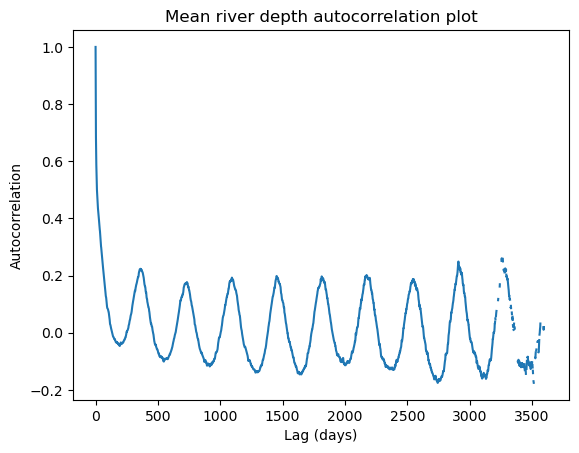

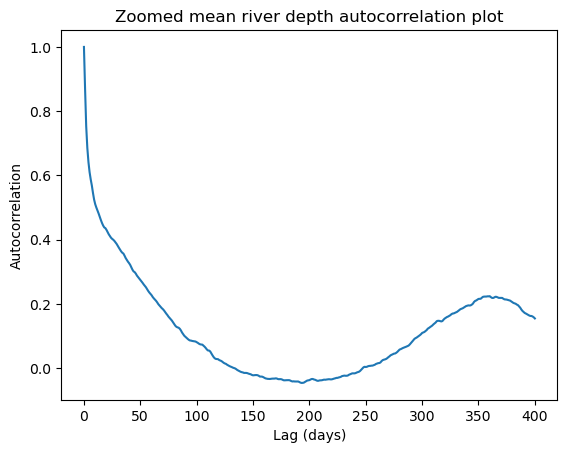

Precipitation


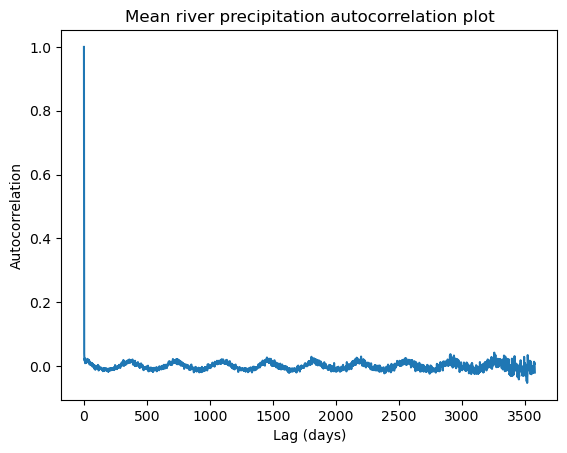

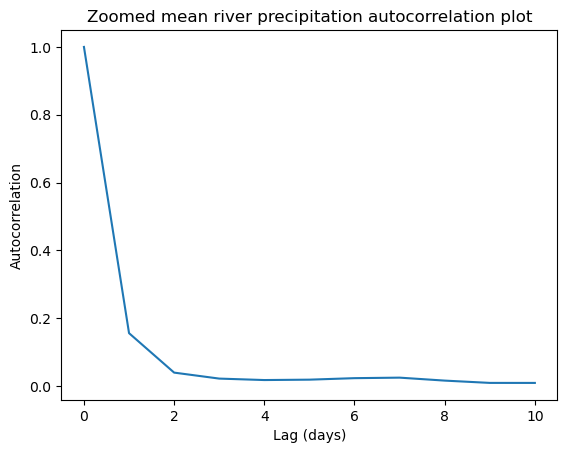

Temperature


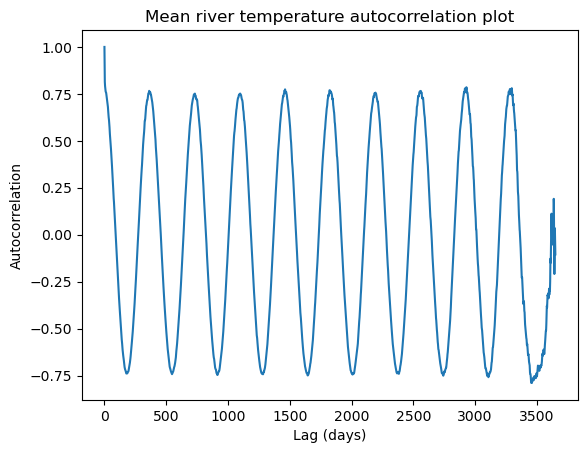

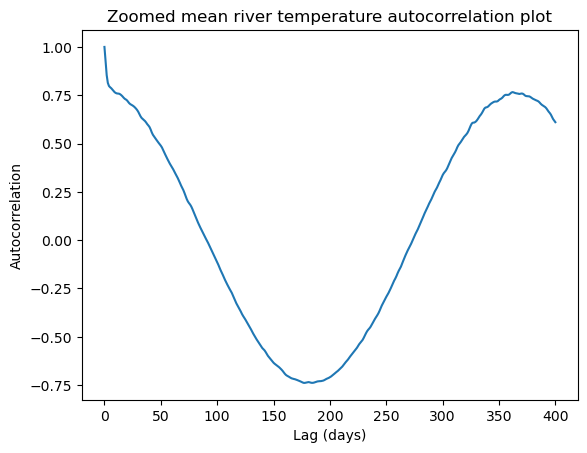

In [14]:
# # Autocorrelation graphs
# # DEPTH
# # 1 river
# print('--- Autcorrelation graphs ---')
# print('Depth')
# pd.plotting.autocorrelation_plot(dtrain_df.iloc[:, 0])
# plt.title(f"River {list(dtrain_df)[0]}'s (index 0) depth autocorrelation plot")
# plt.savefig(f'./presentation docs/autocorr_{list(dtrain_df)[0]}.png', dpi=200)
# plt.show()
# print(f"Each river is unique so find mean of all rivers from now on")

# All rivers
plt.plot(d_autocorrs)
plt.ylabel('Autocorrelation')
plt.xlabel('Lag (days)')
plt.title('Mean river depth autocorrelation plot')
plt.savefig(f'./presentation docs/autocorr_mean_depth.png', dpi=200)
plt.show()

# Zoomed in all rivers
plt.plot(d_autocorrs[:401])
plt.ylabel('Autocorrelation')
plt.xlabel('Lag (days)')
plt.title('Zoomed mean river depth autocorrelation plot')
plt.savefig(f'./presentation docs/autocorr_mean_depth_zoom.png', dpi=200)
plt.show()

# PRECIPITATION
print('Precipitation')
# All rivers
plt.plot(p_autocorrs)
plt.ylabel('Autocorrelation')
plt.xlabel('Lag (days)')
plt.title('Mean river precipitation autocorrelation plot')
plt.savefig(f'./presentation docs/autocorr_mean_precip.png', dpi=200)
plt.show()

# Zoomed in all rivers
plt.plot(p_autocorrs[:11])
plt.ylabel('Autocorrelation')
plt.xlabel('Lag (days)')
plt.title('Zoomed mean river precipitation autocorrelation plot')
plt.savefig(f'./presentation docs/autocorr_mean_precip_zoom.png', dpi=200)
plt.show()

# TEMPERATURE
# All rivers
print('Temperature')
plt.plot(t_autocorrs)
plt.ylabel('Autocorrelation')
plt.xlabel('Lag (days)')
plt.title('Mean river temperature autocorrelation plot')
plt.savefig(f'./presentation docs/autocorr_mean_temp.png', dpi=200)
plt.show()

# Zoomed in all rivers
plt.plot(t_autocorrs[:401])
plt.ylabel('Autocorrelation')
plt.xlabel('Lag (days)')
plt.title('Zoomed mean river temperature autocorrelation plot')
plt.savefig(f'./presentation docs/autocorr_mean_temp_zoom.png', dpi=200)
plt.show()

In [17]:
threshold = 0.35
for idx, entry in enumerate(d_autocorrs):
    if entry < threshold:
        print(f'Depth correlation under {threshold} on day {idx}')
        break
for idx, entry in enumerate(p_autocorrs):
    if entry < threshold:
        print(f'Precipitation correlation under {threshold} on day {idx}')
        break
for idx, entry in enumerate(t_autocorrs):
    if entry < threshold:
        print(f'Temperature correlation under {threshold} on day {idx}')
        break

Depth correlation under 0.35 on day 37
Precipitation correlation under 0.35 on day 1
Temperature correlation under 0.35 on day 63


In [18]:
from statsmodels.tsa.arima.model import ARIMA

In [23]:
# 1.29gb per riv, 50 rivers takes 1hr and crashes it
entries = 5420 * 5 # number of rivers
d_series = dtrain_df.to_numpy().reshape(-1)[:entries]
p_series = ptrain_df.to_numpy().reshape(-1)[:entries]
t_series = ptrain_df.to_numpy().reshape(-1)[:entries]
exog = np.stack((p_series, t_series), axis=-1)

In [ ]:
model = ARIMA(endog=d_series, exog=exog, order=(49, 1, 0))
model_fit = model.fit()

In [ ]:
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)

In [ ]:
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
plt.savefig('testimage.png')
# summary stats of residuals
print(residuals.describe())

In [ ]:
print(model_fit.summary())